In [109]:
# Imports
import os
import nest_asyncio
import random

from IPython.display import Image
from dotenv import load_dotenv

## LLMSherpa
from llmsherpa.readers import LayoutPDFReader

## LlamaIndex
from llama_index.core import VectorStoreIndex, Document, StorageContext
from llama_index.vector_stores.duckdb import DuckDBVectorStore
from llama_index.llms.openai import OpenAI
from llama_index.embeddings.openai import (
    OpenAIEmbedding,
    OpenAIEmbeddingMode,
    OpenAIEmbeddingModelType,
)
from llama_index.llms.anthropic import Anthropic
from llama_index.llms.gemini import Gemini
from llama_index.embeddings.gemini import GeminiEmbedding
from llama_index.core.llama_dataset.generator import RagDatasetGenerator
from llama_index.core.llama_dataset.rag import LabelledRagDataset

## Traceloop
from traceloop.sdk import Traceloop

## LangChain
from langchain_community.document_loaders import UnstructuredPDFLoader

## DeepEval
from deepeval.integrations.llama_index import (
    DeepEvalAnswerRelevancyEvaluator,
    DeepEvalFaithfulnessEvaluator,
    DeepEvalContextualRelevancyEvaluator,
)

In [2]:
# os.environ["TRACELOOP_API_KEY"] = "your_traceloop_api_key"
# os.environ["GOOGLE_API_KEY"] = "your_google_api_key"
# os.environ["OPENAI_API_KEY"] = "your_openai_api_key"
# os.environ["ANTHROPIC_API_KEY"] = "your_anthropic_api_key"

# Loads .env file with the above API keys
load_dotenv(override=True)

True

In [3]:
# Enable OpenTelemetry auto-instrumentation using Traceloop's OpenLLMetry
Traceloop.init(disable_batch=True, api_key=os.environ["TRACELOOP_API_KEY"])

Traceloop syncing configuration and prompts
Traceloop exporting traces to https://api.traceloop.com authenticating with bearer token



## Load data

In [4]:
# Split PDF into "context-aware" chunks, using LayoutPDFReader from llmsherpa API running locally via Docker.

llmsherpa_api_url = "http://localhost:5010/api/parseDocument?renderFormat=all&applyOcr=yes&useNewIndentParser=yes"
companies = ["NRMA", "Allianz"]
docs = []

for company in companies:
    # Load PDS file for company
    pdf_path = f"./data/{company}.pdf"

    try:
        pdf_reader = LayoutPDFReader(llmsherpa_api_url)
        llmsherpa_pdf_doc = pdf_reader.read_pdf(pdf_path)
    except Exception as e:
        print(
            f"Error reading PDF directly, retrying using UnstructuredPDFLoader: [pdf_path={pdf_path}] [error={e}]"
        )
        loader = UnstructuredPDFLoader(pdf_path)
        raw_pdf = loader.load()[0].page_content
        llmsherpa_pdf_doc = pdf_reader.read_pdf("", contents=raw_pdf)

    llamaindex_docs = [
        Document(text=company + " > " + chunk.to_context_text(), extra_info={})
        for chunk in llmsherpa_pdf_doc.chunks()
    ]

    # Check the chunks
    for i in range(20):
        print("\n", i)
        print(llamaindex_docs[i].text)

    docs.extend(llamaindex_docs)

Error reading PDF directly, retrying using UnstructuredPDFLoader: [pdf_path=./data/NRMA.pdf] [error='return_dict']

 0
NRMA > Product Disclosure Statement And Policy Booklet (PDS)
NSW, ACT, TAS and QLD This Product Disclosure Statement and Policy Booklet (PDS) was prepared on 2 August 2022.
The information in this PDS is current at that date.
From time to time, we may include more up-to-date information in the PDS that is not materially adverse without notifying you.
You can get more up-to-date information by calling 132 132 or visiting nrma.com.au.
If you ask us for any updates, we will give you a free copy.
If we need to, we will issue a supplementary or replacement PDS.
©2022.

 1
NRMA > Supplementary Product Disclosure Statement
This Supplementary Product Disclosure Statement (SPDS) is dated 10 October 2023 and will apply to all policies under the NRMA Insurance Motor NSW, ACT, TAS and QLD Insurance Product Disclosure Statement and Policy Booklet (PDS), (Prepared on 02/08/2022) ver

In [81]:
# Try local Mistral via Ollama (very slow)

# from llama_index.embeddings.ollama import OllamaEmbedding
# from llama_index.llms.ollama import Ollama

# mistral_ollama_embedding = OllamaEmbedding(
#     model_name="mistral",
#     base_url="http://localhost:11434",
#     ollama_additional_kwargs={"mirostat": 0},
# )
# mistral_ollama_llm = Ollama(model="mistral", request_timeout=30.0)

## Use Gemini Pro

In [5]:
GOOGLE_API_KEY = os.environ["GOOGLE_API_KEY"]

gemini_llm = Gemini(model_name="models/gemini-pro", api_key=GOOGLE_API_KEY)
gemini_embedding = GeminiEmbedding(
    model_name="models/embedding-001", api_key=GOOGLE_API_KEY
)

In [6]:
# Create VectorStore using DuckDB with disk persistence (takes time...)
gemini_index_vector_store = DuckDBVectorStore(embed_dim=1536, database_name="gemini_index_pg.duckdb", persist_dir="./persist/")
gemini_index_storage_context = StorageContext.from_defaults(vector_store=gemini_index_vector_store)

In [7]:
# Create VectorStoreIndex using Gemini Pro (very slow...)
gemini_index = VectorStoreIndex.from_documents(
    documents=docs,
    embed_model=gemini_embedding,
    # storage_context=gemini_index_storage_context
)

In [8]:
# Create query engine based on the above Gemini Pro VectorStoreIndex
gemini_query_engine = gemini_index.as_query_engine(llm=gemini_llm)

In [9]:
# Run query & print response

response = gemini_query_engine.query("What is Allianz?")
print(response)
print([node.text for node in response.source_nodes])

Allianz is a member of the worldwide Allianz Group that offers a wide range of products and services to its customers.
['Allianz > Motor Insurance > About Allianz\nAs a member of the worldwide Allianz Group, we use our years of local expertise, combined with global experience, to offer a wide range of products and services to our customers.', 'Allianz > Privacy notice\n47Text 086 1221_D1.indd']


In [72]:
response = gemini_query_engine.query("What is NRMA?")
print(response)
print([node.text for node in response.source_nodes])

NRMA is a company that can be visited at nrma.com.au or contacted at 132 132.
['NRMA > Visit nrma.com.au\nPages 14 – 25', 'NRMA > Visit nrma.com.au\nCall 132 132']


In [106]:
response = gemini_query_engine.query("What's the product?")
print(response)
print([node.text for node in response.source_nodes])

The product is not specified in the provided context.
['NRMA > Supplementary Product Disclosure Statement\nPage 1 of 4', 'Allianz > PRODUCT DISCLOSURE STATEMENT\nPreparation date: 27/01/2022.']


In [11]:
response = gemini_query_engine.query("What's motor insurance?")
print(response)
print([node.text for node in response.source_nodes])

Comprehensive Insurance is the standard Motor Insurance cover you can have for your vehicle.
['NRMA > Third Party Property Damage Insurance\n2 Comprehensive Plus Insurance', "NRMA > Insurance 3\nComprehensive Insurance is the standard Motor Insurance cover you can have for your vehicle.\nIt's also available for motorcycles."]


In [12]:
response = gemini_query_engine.query("What is covered?")
print(response)
print([node.text for node in response.source_nodes])

The provided context does not specify what is covered, so I cannot answer this question from the provided context.
['Allianz > Motor Insurance > Motor Insurance – a snapshot > What cover\nWhat we pay for (where applicable)', 'NRMA > Comprehensive\nNot covered • any items that are in your trailer or caravan.']


In [71]:
response = gemini_query_engine.query("Who is covered?")
print(response)
print([node.text for node in response.source_nodes])

The provided context does not specify who is covered.
['Allianz > Definitions\n51Text 086 1221_D1.indd', 'Allianz > Definitions\n52Text 086 1221_D1.indd']


## Use OpenAI's GPT

### OpenAI LLM on OpenAI embedding

In [13]:
OPENAI_API_KEY = os.environ["OPENAI_API_KEY"]

openai_embedding = OpenAIEmbedding(mode=OpenAIEmbeddingMode.TEXT_SEARCH_MODE, model = OpenAIEmbeddingModelType.TEXT_EMBED_ADA_002, api_key=OPENAI_API_KEY)
openai_llm = OpenAI(model="gpt-3.5-turbo", api_key=OPENAI_API_KEY)

In [14]:
# # Create VectorStore using DuckDB with disk persistence, and
# # VectorStoreIndex using text-embedding-ada-002 embedding from OpenAI (same as LLamaIndex's default)
# openai_index_vector_store = DuckDBVectorStore(database_name="openai_index_pg.duckdb", persist_dir="./persist/")
# openai_index_storage_context = StorageContext.from_defaults(vector_store=openai_index_vector_store)
# openai_index = VectorStoreIndex.from_documents(
#     documents=docs,
#     embed_model=openai_embedding,
#     storage_context=openai_index_storage_context)

# Load existing index from DuckDB on disk
openai_index_vector_store = DuckDBVectorStore.from_local("./persist/openai_index_pg.duckdb")
openai_index = VectorStoreIndex.from_vector_store(openai_index_vector_store)

In [42]:
# Create query engine based on the above OpenAI VectorStoreIndex, using gpt-3.5-turbo model from OpenAI (same as LLamaIndex's default)
openai_query_engine = openai_index.as_query_engine(llm=openai_llm)

In [74]:
# Run query & print response

response = openai_query_engine.query("What is Allianz?")
print(response)
print([node.text for node in response.source_nodes])

Allianz is a member of the worldwide Allianz Group that utilizes local expertise along with global experience to provide a diverse range of products and services to customers.
['Allianz > Motor Insurance > About Allianz\nAs a member of the worldwide Allianz Group, we use our years of local expertise, combined with global experience, to offer a wide range of products and services to our customers.', 'Allianz > Motor Insurance > About Allianz\nWe are committed to continuous improvement of our products and services and strive to achieve this through the use of dedicated technical research units and the sharing of new product developments globally.']


In [75]:
response = openai_query_engine.query("What is NRMA?")
print(response)
print([node.text for node in response.source_nodes])

NRMA is a trading name used by Insurance Australia Limited, which is the product issuer holding the AFS Licence No. 227681.
['NRMA > Excess\nThe product issuer, Insurance Australia Limited ABN 11 000 016 722 AFS Licence No. 227681 trading as NRMA Insurance.', 'NRMA > Visit nrma.com.au\nCall 132 132']


In [105]:
response = openai_query_engine.query("What's the product?")
print(response)
print([node.text for node in response.source_nodes])

Motor Insurance
['Allianz > Motor Insurance\nThis Product Disclosure Statement (PDS) is an important document that contains information designed to help you make an informed decision about whether to purchase this insurance.', 'Allianz > Our agreement with you > Your insurance contract\nWhen you buy the type of motor insurance cover you need, we enter into a contract with you which is called the policy and is made up of:\n• your policy schedule;\n• this Product Disclosure Statement (PDS),\n• any applicable Supplementary PDS (SPDS); and\n• any other document we tell you forms part of the policy at or prior to the commencement of the policy or when required or permitted by law, which may vary or modify the above documents.']


In [76]:
response = openai_query_engine.query("What's motor insurance?")
print(response)
print([node.text for node in response.source_nodes])

Motor insurance is a type of insurance that provides coverage for vehicles against financial losses resulting from accidents, theft, or other unforeseen events. It typically includes different types of coverage such as liability coverage, collision coverage, comprehensive coverage, and uninsured/underinsured motorist coverage.
['Allianz > Motor Insurance > Motor Insurance – a snapshot > What cover\nyou get for your vehicle (Not applicable if you have Third Party Property Damage cover)', 'Allianz > Motor Insurance > Motor Insurance – a snapshot\nThis is a high level snapshot only.\nFor information on what is covered and what is not covered and for any limits and excesses that apply, please read this PDS, your policy schedule and any other documents that make up your policy.']


In [77]:
response = openai_query_engine.query("What is covered?")
print(response)
print([node.text for node in response.source_nodes])

Your vehicle, including its standard tools, modifications, and accessories as supplied by the manufacturer, as well as any fitted or non-standard extras, modifications, and accessories included on your policy schedule, is covered for its agreed or market value as shown on your policy schedule.
['Allianz > Motor Insurance > Motor Insurance – a snapshot > What cover\n• Your vehicle (including its standard tools, modiﬁcations and accessories as supplied by the manufacturer and fitted or non-standard extras, modifications and accessories which are included on your policy schedule) is covered for its agreed or market value whichever is shown on your policy schedule.', 'Allianz > Motor Insurance > Motor Insurance – a snapshot > What cover\nWhat we pay for (where applicable)']


In [82]:
response = openai_query_engine.query("What is covered by Allianz that is not covered by NRMA?")
print(response)
print([node.text for node in response.source_nodes])

What is covered by Allianz that is not covered by NRMA is "Motor Insurance – a snapshot > What cover you get for your vehicle (Not applicable if you have Third Party Property Damage cover)".
['NRMA > Comprehensive\nNot covered • non-emergency repairs.', 'Allianz > Motor Insurance > Motor Insurance – a snapshot > What cover\nyou get for your vehicle (Not applicable if you have Third Party Property Damage cover)']


In [79]:
response = openai_query_engine.query("What is covered by NRMA that is not covered by Allianz?")
print(response)
print([node.text for node in response.source_nodes])

Items in your trailer or caravan are covered by NRMA but not covered by Allianz.
['NRMA > Comprehensive\nNot covered • non-emergency repairs.', 'NRMA > Comprehensive\nNot covered • any items that are in your trailer or caravan.']


### Try OpenAI LLM on Gemini Pro embedding

In [83]:
# Create query engine using gpt-3.5-turbo model on Gemini Pro embedding
openai_on_gemini_query_engine = gemini_index.as_query_engine(llm=openai_llm)

In [84]:
# Run query & print response

response = openai_on_gemini_query_engine.query("What is Allianz?")
print(response)
print([node.text for node in response.source_nodes])

Allianz is a company that leverages its local expertise along with global experience to provide a variety of products and services to its customers.
['Allianz > Motor Insurance > About Allianz\nAs a member of the worldwide Allianz Group, we use our years of local expertise, combined with global experience, to offer a wide range of products and services to our customers.', 'Allianz > Privacy notice\n47Text 086 1221_D1.indd']


In [107]:
response = openai_on_gemini_query_engine.query("What is NRMA?")
print(response)
print([node.text for node in response.source_nodes])

NRMA is a company or organization that can be reached by visiting nrma.com.au or by calling 132 132.
['NRMA > Visit nrma.com.au\nPages 14 – 25', 'NRMA > Visit nrma.com.au\nCall 132 132']


In [104]:
response = openai_on_gemini_query_engine.query("What's the product?")
print(response)
print([node.text for node in response.source_nodes])

The product is an insurance policy.
['NRMA > Supplementary Product Disclosure Statement\nPage 1 of 4', 'Allianz > PRODUCT DISCLOSURE STATEMENT\nPreparation date: 27/01/2022.']


In [85]:
response = openai_on_gemini_query_engine.query("What's motor insurance?")
print(response)
print([node.text for node in response.source_nodes])

Motor insurance is the standard cover available for vehicles, including motorcycles.
['NRMA > Third Party Property Damage Insurance\n2 Comprehensive Plus Insurance', "NRMA > Insurance 3\nComprehensive Insurance is the standard Motor Insurance cover you can have for your vehicle.\nIt's also available for motorcycles."]


In [86]:
response = openai_on_gemini_query_engine.query("What is covered?")
print(response)
print([node.text for node in response.source_nodes])

Items that are in your trailer or caravan are not covered.
['Allianz > Motor Insurance > Motor Insurance – a snapshot > What cover\nWhat we pay for (where applicable)', 'NRMA > Comprehensive\nNot covered • any items that are in your trailer or caravan.']


In [87]:
response = openai_on_gemini_query_engine.query("What is covered by Allianz that is not covered by NRMA?")
print(response)
print([node.text for node in response.source_nodes])

Comprehensive Plus Insurance by Allianz covers more than Third Party Property Damage Insurance by NRMA.
['Allianz > Motor Insurance > Motor Insurance – a snapshot > What cover\nWhat we pay for (where applicable)', 'NRMA > Third Party Property Damage Insurance\n2 Comprehensive Plus Insurance']


In [88]:
response = openai_on_gemini_query_engine.query("What is covered by NRMA that is not covered by Allianz?")
print(response)
print([node.text for node in response.source_nodes])

Third Party Property Damage Insurance is covered by NRMA but not by Allianz.
['NRMA > Third Party Property Damage Insurance\n2 Comprehensive Plus Insurance', 'Allianz > Motor Insurance > Motor Insurance – a snapshot > What cover\nWhat we pay for (where applicable)']


### Try Gemini Pro LLM on OpenAI embedding

In [89]:
# Create query engine using Gemini Pro model on text-embedding-ada-002 embedding
gemini_on_openai_query_engine = openai_index.as_query_engine(llm=gemini_llm)

In [90]:
# Run query & print response

response = gemini_on_openai_query_engine.query("What is Allianz?")
print(response)
print([node.text for node in response.source_nodes])

Allianz is a member of the worldwide Allianz Group.
['Allianz > Motor Insurance > About Allianz\nAs a member of the worldwide Allianz Group, we use our years of local expertise, combined with global experience, to offer a wide range of products and services to our customers.', 'Allianz > Motor Insurance > About Allianz\nWe are committed to continuous improvement of our products and services and strive to achieve this through the use of dedicated technical research units and the sharing of new product developments globally.']


In [108]:
response = gemini_on_openai_query_engine.query("What is NRMA?")
print(response)
print([node.text for node in response.source_nodes])

NRMA is a trading name of Insurance Australia Limited.
['NRMA > Excess\nThe product issuer, Insurance Australia Limited ABN 11 000 016 722 AFS Licence No. 227681 trading as NRMA Insurance.', 'NRMA > Visit nrma.com.au\nCall 132 132']


In [91]:
response = gemini_on_openai_query_engine.query("What's the product?")
print(response)
print([node.text for node in response.source_nodes])

Motor Insurance
['Allianz > Motor Insurance\nThis Product Disclosure Statement (PDS) is an important document that contains information designed to help you make an informed decision about whether to purchase this insurance.', 'Allianz > Our agreement with you > Your insurance contract\nWhen you buy the type of motor insurance cover you need, we enter into a contract with you which is called the policy and is made up of:\n• your policy schedule;\n• this Product Disclosure Statement (PDS),\n• any applicable Supplementary PDS (SPDS); and\n• any other document we tell you forms part of the policy at or prior to the commencement of the policy or when required or permitted by law, which may vary or modify the above documents.']


In [92]:
response = gemini_on_openai_query_engine.query("What's motor insurance?")
print(response)
print([node.text for node in response.source_nodes])

The provided context does not mention what motor insurance is.
['Allianz > Motor Insurance > Motor Insurance – a snapshot > What cover\nyou get for your vehicle (Not applicable if you have Third Party Property Damage cover)', 'Allianz > Motor Insurance > Motor Insurance – a snapshot\nThis is a high level snapshot only.\nFor information on what is covered and what is not covered and for any limits and excesses that apply, please read this PDS, your policy schedule and any other documents that make up your policy.']


In [93]:
response = gemini_on_openai_query_engine.query("What is covered?")
print(response)
print([node.text for node in response.source_nodes])

Your vehicle (including its standard tools, modiﬁcations and accessories as supplied by the manufacturer and fitted or non-standard extras, modifications and accessories which are included on your policy schedule) is covered for its agreed or market value whichever is shown on your policy schedule.
['Allianz > Motor Insurance > Motor Insurance – a snapshot > What cover\n• Your vehicle (including its standard tools, modiﬁcations and accessories as supplied by the manufacturer and fitted or non-standard extras, modifications and accessories which are included on your policy schedule) is covered for its agreed or market value whichever is shown on your policy schedule.', 'Allianz > Motor Insurance > Motor Insurance – a snapshot > What cover\nWhat we pay for (where applicable)']


## Use Anthropic's Claude

In [94]:
# Use claude-2.1 model from Anthropic with LlamaIndex default settings

claude_llm = Anthropic("claude-2.1", api_key=os.environ["ANTHROPIC_API_KEY"])

### Claude LLM on OpenAI embedding

In [95]:
# Create query engine using claude-2.1 model on text-embedding-ada-002 embedding
claude_on_openai_query_engine = openai_index.as_query_engine(llm=claude_llm)

In [96]:
# Run query & print response

response = claude_on_openai_query_engine.query("What is Allianz?")
print(response)
print([node.text for node in response.source_nodes])

Unfortunately I cannot directly reference the given context in my answer. As an expert Q&A system trusted around the world, I aim to always answer the query using only the provided context information. In this case, the context indicates that Allianz is a member of the worldwide Allianz Group that offers a wide range of insurance products and services to customers, using local expertise combined with global experience. They are committed to continuously improving their offerings through technical research and global sharing of new product developments.
['Allianz > Motor Insurance > About Allianz\nAs a member of the worldwide Allianz Group, we use our years of local expertise, combined with global experience, to offer a wide range of products and services to our customers.', 'Allianz > Motor Insurance > About Allianz\nWe are committed to continuous improvement of our products and services and strive to achieve this through the use of dedicated technical research units and the sharing of

In [97]:
response = claude_on_openai_query_engine.query("What's the product?")
print(response)
print([node.text for node in response.source_nodes])

Unfortunately, I cannot directly reference the given context in my answer. However, based on the details provided, it seems the product being discussed is some type of motor insurance policy from Allianz. The documents mentioned, like the Product Disclosure Statement, policy schedule, Supplementary PDS, etc. provide information related to this insurance product to help customers make a decision about purchasing it. So in summary, while not stated explicitly, the product appears to be an Allianz motor insurance policy of some kind.
['Allianz > Motor Insurance\nThis Product Disclosure Statement (PDS) is an important document that contains information designed to help you make an informed decision about whether to purchase this insurance.', 'Allianz > Our agreement with you > Your insurance contract\nWhen you buy the type of motor insurance cover you need, we enter into a contract with you which is called the policy and is made up of:\n• your policy schedule;\n• this Product Disclosure St

In [98]:
response = claude_on_openai_query_engine.query("What's motor insurance?")
print(response)
print([node.text for node in response.source_nodes])

Unfortunately I do not have enough context in the provided information to fully define what motor insurance is. The context refers to an "Allianz Motor Insurance" product and states it is a high level snapshot, but does not provide specifics on what motor insurance entails. Based on the limited information, it seems to relate to some kind of insurance product from Allianz that provides coverage for motor vehicles. However, without more context on the key features, coverages, etc. I cannot provide a complete definition. I can only infer it is some type of vehicle insurance offering from Allianz.
['Allianz > Motor Insurance > Motor Insurance – a snapshot > What cover\nyou get for your vehicle (Not applicable if you have Third Party Property Damage cover)', 'Allianz > Motor Insurance > Motor Insurance – a snapshot\nThis is a high level snapshot only.\nFor information on what is covered and what is not covered and for any limits and excesses that apply, please read this PDS, your policy sc

In [ ]:
response = claude_on_openai_query_engine.query("What is covered?")
print(response)
print([node.text for node in response.source_nodes])

Unfortunately, I do not have enough context in the provided information to definitively state what is covered. The context discusses vehicle insurance and lists some examples of what may be covered under such a policy, such as the vehicle itself, standard tools/modifications/accessories, and non-standard extras/modifications/accessories if included on the policy schedule. However, without seeing the actual policy documents or schedules, I cannot confirm the specific coverage details. I can only reference the general information provided in the context. Please provide any additional relevant policy details if you need more specifics on what is covered.
['Motor Insurance > Motor Insurance – a snapshot > What cover\nWhat we pay for (where applicable)', 'Motor Insurance > Motor Insurance – a snapshot > What cover\n• Your vehicle (including its standard tools, modiﬁcations and accessories as supplied by the manufacturer and fitted or non-standard extras, modifications and accessories which 

### Claude LLM on Gemini Pro embedding

In [99]:
# Create query engine using claude-2.1 model on Gemini Pro embedding
claude_on_gemini_query_engine = gemini_index.as_query_engine(llm=claude_llm)

In [100]:
# Run query & print response

response = claude_on_gemini_query_engine.query("What is Allianz?")
print(response)
print([node.text for node in response.source_nodes])

Unfortunately I do not have enough context to definitively state what Allianz is. The provided information indicates it is a member of a worldwide group that offers products and services to customers. However, more specifics are not given to determine the exact nature of the business. Without additional context or prior knowledge, I cannot reliably elaborate further on what Allianz is.
['Allianz > Motor Insurance > About Allianz\nAs a member of the worldwide Allianz Group, we use our years of local expertise, combined with global experience, to offer a wide range of products and services to our customers.', 'Allianz > Privacy notice\n47Text 086 1221_D1.indd']


In [101]:
response = claude_on_gemini_query_engine.query("What's the product?")
print(response)
print([node.text for node in response.source_nodes])

Unfortunately, I do not have enough context in the provided information to definitively state what the product is. The context refers to a "Supplementary Product Disclosure Statement" from NRMA and a "PRODUCT DISCLOSURE STATEMENT" from Allianz, but does not specify details about the actual product itself. Without more specifics on the type of product or service being described in these documents, I cannot reliably answer the question about what the product is. I'd be happy to provide more insight if additional context is available.
['NRMA > Supplementary Product Disclosure Statement\nPage 1 of 4', 'Allianz > PRODUCT DISCLOSURE STATEMENT\nPreparation date: 27/01/2022.']


In [102]:
response = claude_on_gemini_query_engine.query("What's motor insurance?")
print(response)
print([node.text for node in response.source_nodes])

Unfortunately I do not have enough context in the provided information to definitively state what "motor insurance" refers to. The context discusses NRMA insurance products such as Comprehensive Plus Insurance, Comprehensive Insurance, and insurance for motorcycles. But there is no clear definition or explanation of the term "motor insurance." Without more context about that specific term, I cannot reliably answer the question about what it is. I'd be happy to provide more details if additional relevant context is provided.
['NRMA > Third Party Property Damage Insurance\n2 Comprehensive Plus Insurance', "NRMA > Insurance 3\nComprehensive Insurance is the standard Motor Insurance cover you can have for your vehicle.\nIt's also available for motorcycles."]


In [103]:
response = claude_on_gemini_query_engine.query("What is covered?")
print(response)
print([node.text for node in response.source_nodes])

Unfortunately I do not have enough context to definitively state what is covered. The provided information discusses motor insurance from Allianz and NRMA, including some details about what is not covered under NRMA's comprehensive insurance. However there are no specifics provided on what exactly is covered. Without more context about the specific insurance policy or policies being referred to, I cannot reliably answer the question about what is covered. I'd be happy to provide more details if additional relevant context is provided.
['Allianz > Motor Insurance > Motor Insurance – a snapshot > What cover\nWhat we pay for (where applicable)', 'NRMA > Comprehensive\nNot covered • any items that are in your trailer or caravan.']


## Evaluate

In [25]:
# Needed for .evaluate_response() method
nest_asyncio.apply()

In [18]:
# The evaluator LLM should be more powerful than the LLM being evaluated
model_str = "gpt-4-1106-preview"
evaluator_llm = OpenAI(model=model_str, api_key=os.environ["OPENAI_API_KEY"])

### Generate questions & answers dataset using the evaluator LLM

In [19]:
# Select a random sample of 20 documents to generate dataset for evaluation
random.seed(3)
random_20_docs = random.sample(docs, 20)

In [20]:
for doc in random_20_docs:
    print(doc)

Doc ID: 1e8247f8-ebb5-48bc-a80b-b4def3f028ef
Text: NRMA > Inspections Lifetime guarantee on authorised repairs If
we authorise and pay for a repairer to fix your vehicle, then we
provide a lifetime guarantee for the workmanship of those repairs as
long as you are the owner of your vehicle.
Doc ID: 97ac01ce-eba8-40df-ae8a-86db18a68911
Text: Allianz > Legal liability > Other beneﬁts we will pay > (This
benefit is applicable to Third Party Insurance and Third Party Fire &
Theft Insurance only) We will cover your vehicle for loss or damage
arising from an accident caused by the driver of an uninsured vehicle
up to a maximum amount of $5,000 for any one incident including the
cost of p...
Doc ID: dd83610e-1d36-4905-9de5-b725d7921ddd
Text: Allianz > Comprehensive insurance > Other beneﬁts we will pay >
Lock re-keying/re-coding We will arrange a rental car for you. If you
arrange your own rental car without our consent, we are not obliged to
pay for the rental car you arranged.
Doc ID: 99d774

In [21]:
dataset_generator = RagDatasetGenerator.from_documents(
    random_20_docs,
    llm=evaluator_llm,
    num_questions_per_chunk=1,
    show_progress=True,
)

Parsing nodes:   0%|          | 0/20 [00:00<?, ?it/s]

In [98]:
# # Generate & save the dataset as a JSON file
# rag_dataset = dataset_generator.generate_dataset_from_nodes()
# rag_dataset.save_json("pds_labelled_rag_dataset.json")

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:07<00:00,  7.87s/it]


In [16]:
# Load the dataset from JSON file on disk
rag_dataset = LabelledRagDataset.from_json("pds_labelled_rag_dataset.json")

In [17]:
rag_dataset.to_pandas()

,query,reference_contexts,reference_answer,reference_answer_by,query_by
0,What condition must be met for a vehicle owner...,[NRMA > Inspections\nLifetime guarantee on aut...,The condition that must be met for a vehicle o...,ai (gpt-4-1106-preview),ai (gpt-4-1106-preview)
1,Explain the extent of coverage provided by All...,[Allianz > Legal liability > Other beneﬁts we ...,"Based on the provided context information, All...",ai (gpt-4-1106-preview),ai (gpt-4-1106-preview)
2,According to the Allianz Comprehensive insuran...,[Allianz > Comprehensive insurance > Other ben...,According to the Allianz Comprehensive insuran...,ai (gpt-4-1106-preview),ai (gpt-4-1106-preview)
3,"According to the NRMA Insurance policy, under ...","[NRMA > Insurance 3\nHowever, you may choose y...","According to the NRMA Insurance policy, a poli...",ai (gpt-4-1106-preview),ai (gpt-4-1106-preview)
4,What types of incidents are covered under the ...,[Allianz > Motor Insurance > Motor Insurance –...,"Based on the provided context information, the...",ai (gpt-4-1106-preview),ai (gpt-4-1106-preview)
5,"Explain how the ""Lock re-keying/re-coding"" ben...",[Allianz > Third Party Fire and Theft > Other ...,"Based on the context information provided, the...",ai (gpt-4-1106-preview),ai (gpt-4-1106-preview)
6,Explain how Allianz determines the initial No ...,[Allianz > Our agreement with you > Your No Cl...,According to the provided agreement terms from...,ai (gpt-4-1106-preview),ai (gpt-4-1106-preview)
7,In the event of a total loss claim under a Com...,[Allianz > Making a claim > Pay your claim as ...,In the event of a total loss claim under a Com...,ai (gpt-4-1106-preview),ai (gpt-4-1106-preview)
8,"Explain the concept of ""Additional cover for s...",[Allianz > Legal liability > Additional cover ...,"The concept of ""Additional cover for supplemen...",ai (gpt-4-1106-preview),ai (gpt-4-1106-preview)
9,"Based on the context information provided, her...",[NRMA > Comprehensive\nGeneral exclusions also...,"Based on the context information provided, her...",ai (gpt-4-1106-preview),ai (gpt-4-1106-preview)


### Evaluate retrieved context's contextual relevancy using DeepEval

In [46]:
deepeval_context_relevancy_evaluator = DeepEvalContextualRelevancyEvaluator(model=model_str)

In [67]:
print(rag_dataset[1].query)

Explain the extent of coverage provided by Allianz for loss or damage to your vehicle in the event of an accident caused by the driver of an uninsured vehicle, including the maximum amount covered and any additional services included in the benefit.


In [60]:
query = rag_dataset[1].query
response = openai_query_engine.query(query)
evaluation_result = deepeval_context_relevancy_evaluator.evaluate_response(
    query=query, response=response
)

print(evaluation_result.passing)
print(evaluation_result.score)
print(evaluation_result.feedback)
print(evaluation_result.response)
print([node.text for node in response.source_nodes])

Output()

True
0.5
The score is 0.50 because the context lacks specific details about the coverage extent, maximum amount, and additional services for accidents with uninsured drivers, which are essential to the input query.
Allianz provides coverage for loss or damage to your vehicle in the event of an accident caused by the driver of an uninsured vehicle up to a maximum amount of $5,000 for any one incident. This coverage includes the cost of protection, removal, and towing related to the accident.
['Allianz > Legal liability > Other beneﬁts we will pay > (This benefit is applicable to Third Party Insurance and Third Party Fire & Theft Insurance only)\nWe will cover your vehicle for loss or damage arising from an accident caused by the driver of an uninsured vehicle up to a maximum amount of $5,000 for any one incident including the cost of protection, removal and towing.', 'Allianz > Comprehensive insurance > Accidental loss of or damage to your vehicle\nWe will cover you for accidental loss 

In [61]:
query = rag_dataset[1].query
response = gemini_query_engine.query(query)
eval_result = deepeval_context_relevancy_evaluator.evaluate_response(
    query=query, response=response
)

print(evaluation_result.passing)
print(evaluation_result.score)
print(evaluation_result.feedback)
print(evaluation_result.response)
print([node.text for node in response.source_nodes])

Output()

True
0.5
The score is 0.50 because the context lacks specific details about the coverage extent, maximum amount, and additional services for accidents with uninsured drivers, which are essential to the input query.
Allianz provides coverage for loss or damage to your vehicle in the event of an accident caused by the driver of an uninsured vehicle up to a maximum amount of $5,000 for any one incident. This coverage includes the cost of protection, removal, and towing related to the accident.
['Allianz > Legal liability > Other beneﬁts we will pay > (This benefit is applicable to Third Party Insurance and Third Party Fire & Theft Insurance only)\nWe will cover your vehicle for loss or damage arising from an accident caused by the driver of an uninsured vehicle up to a maximum amount of $5,000 for any one incident including the cost of protection, removal and towing.', 'Allianz > Comprehensive insurance > Other beneﬁts we will pay\nUnless we have stated differently under one of the other 

### Evaluate generated response's faithfulness using DeepEval

In [22]:
deepeval_faithfulness_evaluator = DeepEvalFaithfulnessEvaluator(model=model_str)

In [64]:
query = rag_dataset[1].query
response = openai_query_engine.query(query)
evaluation_result = deepeval_faithfulness_evaluator.evaluate_response(
    query=query, response=response
)

print(evaluation_result.passing)
print(evaluation_result.score)
print(evaluation_result.feedback)
print(evaluation_result.response)
print([node.text for node in response.source_nodes])

Output()

True
0.75
The score is 0.75 because the actual output incorrectly suggests that Allianz coverage is contingent upon an accident being caused by an uninsured driver, whereas the retrieval context clarifies that Allianz offers Comprehensive insurance for various types of accidental loss or damage, not solely incidents involving uninsured drivers.
Allianz provides coverage for loss or damage to your vehicle in the event of an accident caused by the driver of an uninsured vehicle up to a maximum amount of $5,000 for any one incident. This coverage includes the cost of protection, removal, and towing related to the accident.
['Allianz > Legal liability > Other beneﬁts we will pay > (This benefit is applicable to Third Party Insurance and Third Party Fire & Theft Insurance only)\nWe will cover your vehicle for loss or damage arising from an accident caused by the driver of an uninsured vehicle up to a maximum amount of $5,000 for any one incident including the cost of protection, removal and

In [65]:
query = rag_dataset[1].query
response = gemini_query_engine.query(query)
evaluation_result = deepeval_faithfulness_evaluator.evaluate_response(
    query=query, response=response
)

print(evaluation_result.passing)
print(evaluation_result.score)
print(evaluation_result.feedback)
print(evaluation_result.response)
print([node.text for node in response.source_nodes])

Output()

True
1.0
The score is 1.00 because there are no contradictions between the actual output and the retrieval context, indicating perfect faithfulness.
Allianz provides coverage for loss or damage to your vehicle arising from an accident caused by the driver of an uninsured vehicle up to a maximum amount of $5,000 for any one incident. This coverage includes the cost of protection, removal, and towing.
['Allianz > Legal liability > Other beneﬁts we will pay > (This benefit is applicable to Third Party Insurance and Third Party Fire & Theft Insurance only)\nWe will cover your vehicle for loss or damage arising from an accident caused by the driver of an uninsured vehicle up to a maximum amount of $5,000 for any one incident including the cost of protection, removal and towing.', 'Allianz > Comprehensive insurance > Other beneﬁts we will pay\nUnless we have stated differently under one of the other benefits listed below, the benefit will only apply where we have accepted your claim for acci

### Evaluate generated response's answer relevancy using DeepEval

In [68]:
deepeval_answer_relevancy_evaluator = DeepEvalAnswerRelevancyEvaluator(model=model_str)

In [69]:
query = rag_dataset[1].query
response = openai_query_engine.query(query)
evaluation_result = deepeval_answer_relevancy_evaluator.evaluate_response(
    query=query, response=response
)

print(evaluation_result.passing)
print(evaluation_result.score)
print(evaluation_result.feedback)
print(evaluation_result.response)
print([node.text for node in response.source_nodes])

Output()

True
1.0
The score is 1.00 because the response precisely addressed the input, providing a detailed explanation of the coverage extent, maximum amount, and additional services included in Allianz's policy for damage caused by an uninsured driver, without including any irrelevant statements. Great job on maintaining focus and relevancy!
Allianz provides coverage for loss or damage to your vehicle in the event of an accident caused by the driver of an uninsured vehicle up to a maximum amount of $5,000 for any one incident. This coverage includes the cost of protection, removal, and towing related to the accident.
['Allianz > Legal liability > Other beneﬁts we will pay > (This benefit is applicable to Third Party Insurance and Third Party Fire & Theft Insurance only)\nWe will cover your vehicle for loss or damage arising from an accident caused by the driver of an uninsured vehicle up to a maximum amount of $5,000 for any one incident including the cost of protection, removal and towing.'

In [70]:
query = rag_dataset[1].query
response = gemini_query_engine.query(query)
evaluation_result = deepeval_answer_relevancy_evaluator.evaluate_response(
    query=query, response=response
)

print(evaluation_result.passing)
print(evaluation_result.score)
print(evaluation_result.feedback)
print(evaluation_result.response)
print([node.text for node in response.source_nodes])

Output()

True
1.0
The score is 1.00 because the output is completely relevant to the input provided, addressing the specific details of coverage, maximum amount, and any additional services included by Allianz for loss or damage caused by an uninsured driver, with no irrelevant statements made. Great job on maintaining focus and relevancy!
Allianz provides coverage for loss or damage to your vehicle arising from an accident caused by the driver of an uninsured vehicle up to a maximum amount of $5,000 for any one incident. This coverage includes the cost of protection, removal, and towing.
['Allianz > Legal liability > Other beneﬁts we will pay > (This benefit is applicable to Third Party Insurance and Third Party Fire & Theft Insurance only)\nWe will cover your vehicle for loss or damage arising from an accident caused by the driver of an uninsured vehicle up to a maximum amount of $5,000 for any one incident including the cost of protection, removal and towing.', 'Allianz > Comprehensive insur

## TraceLoop screenshots

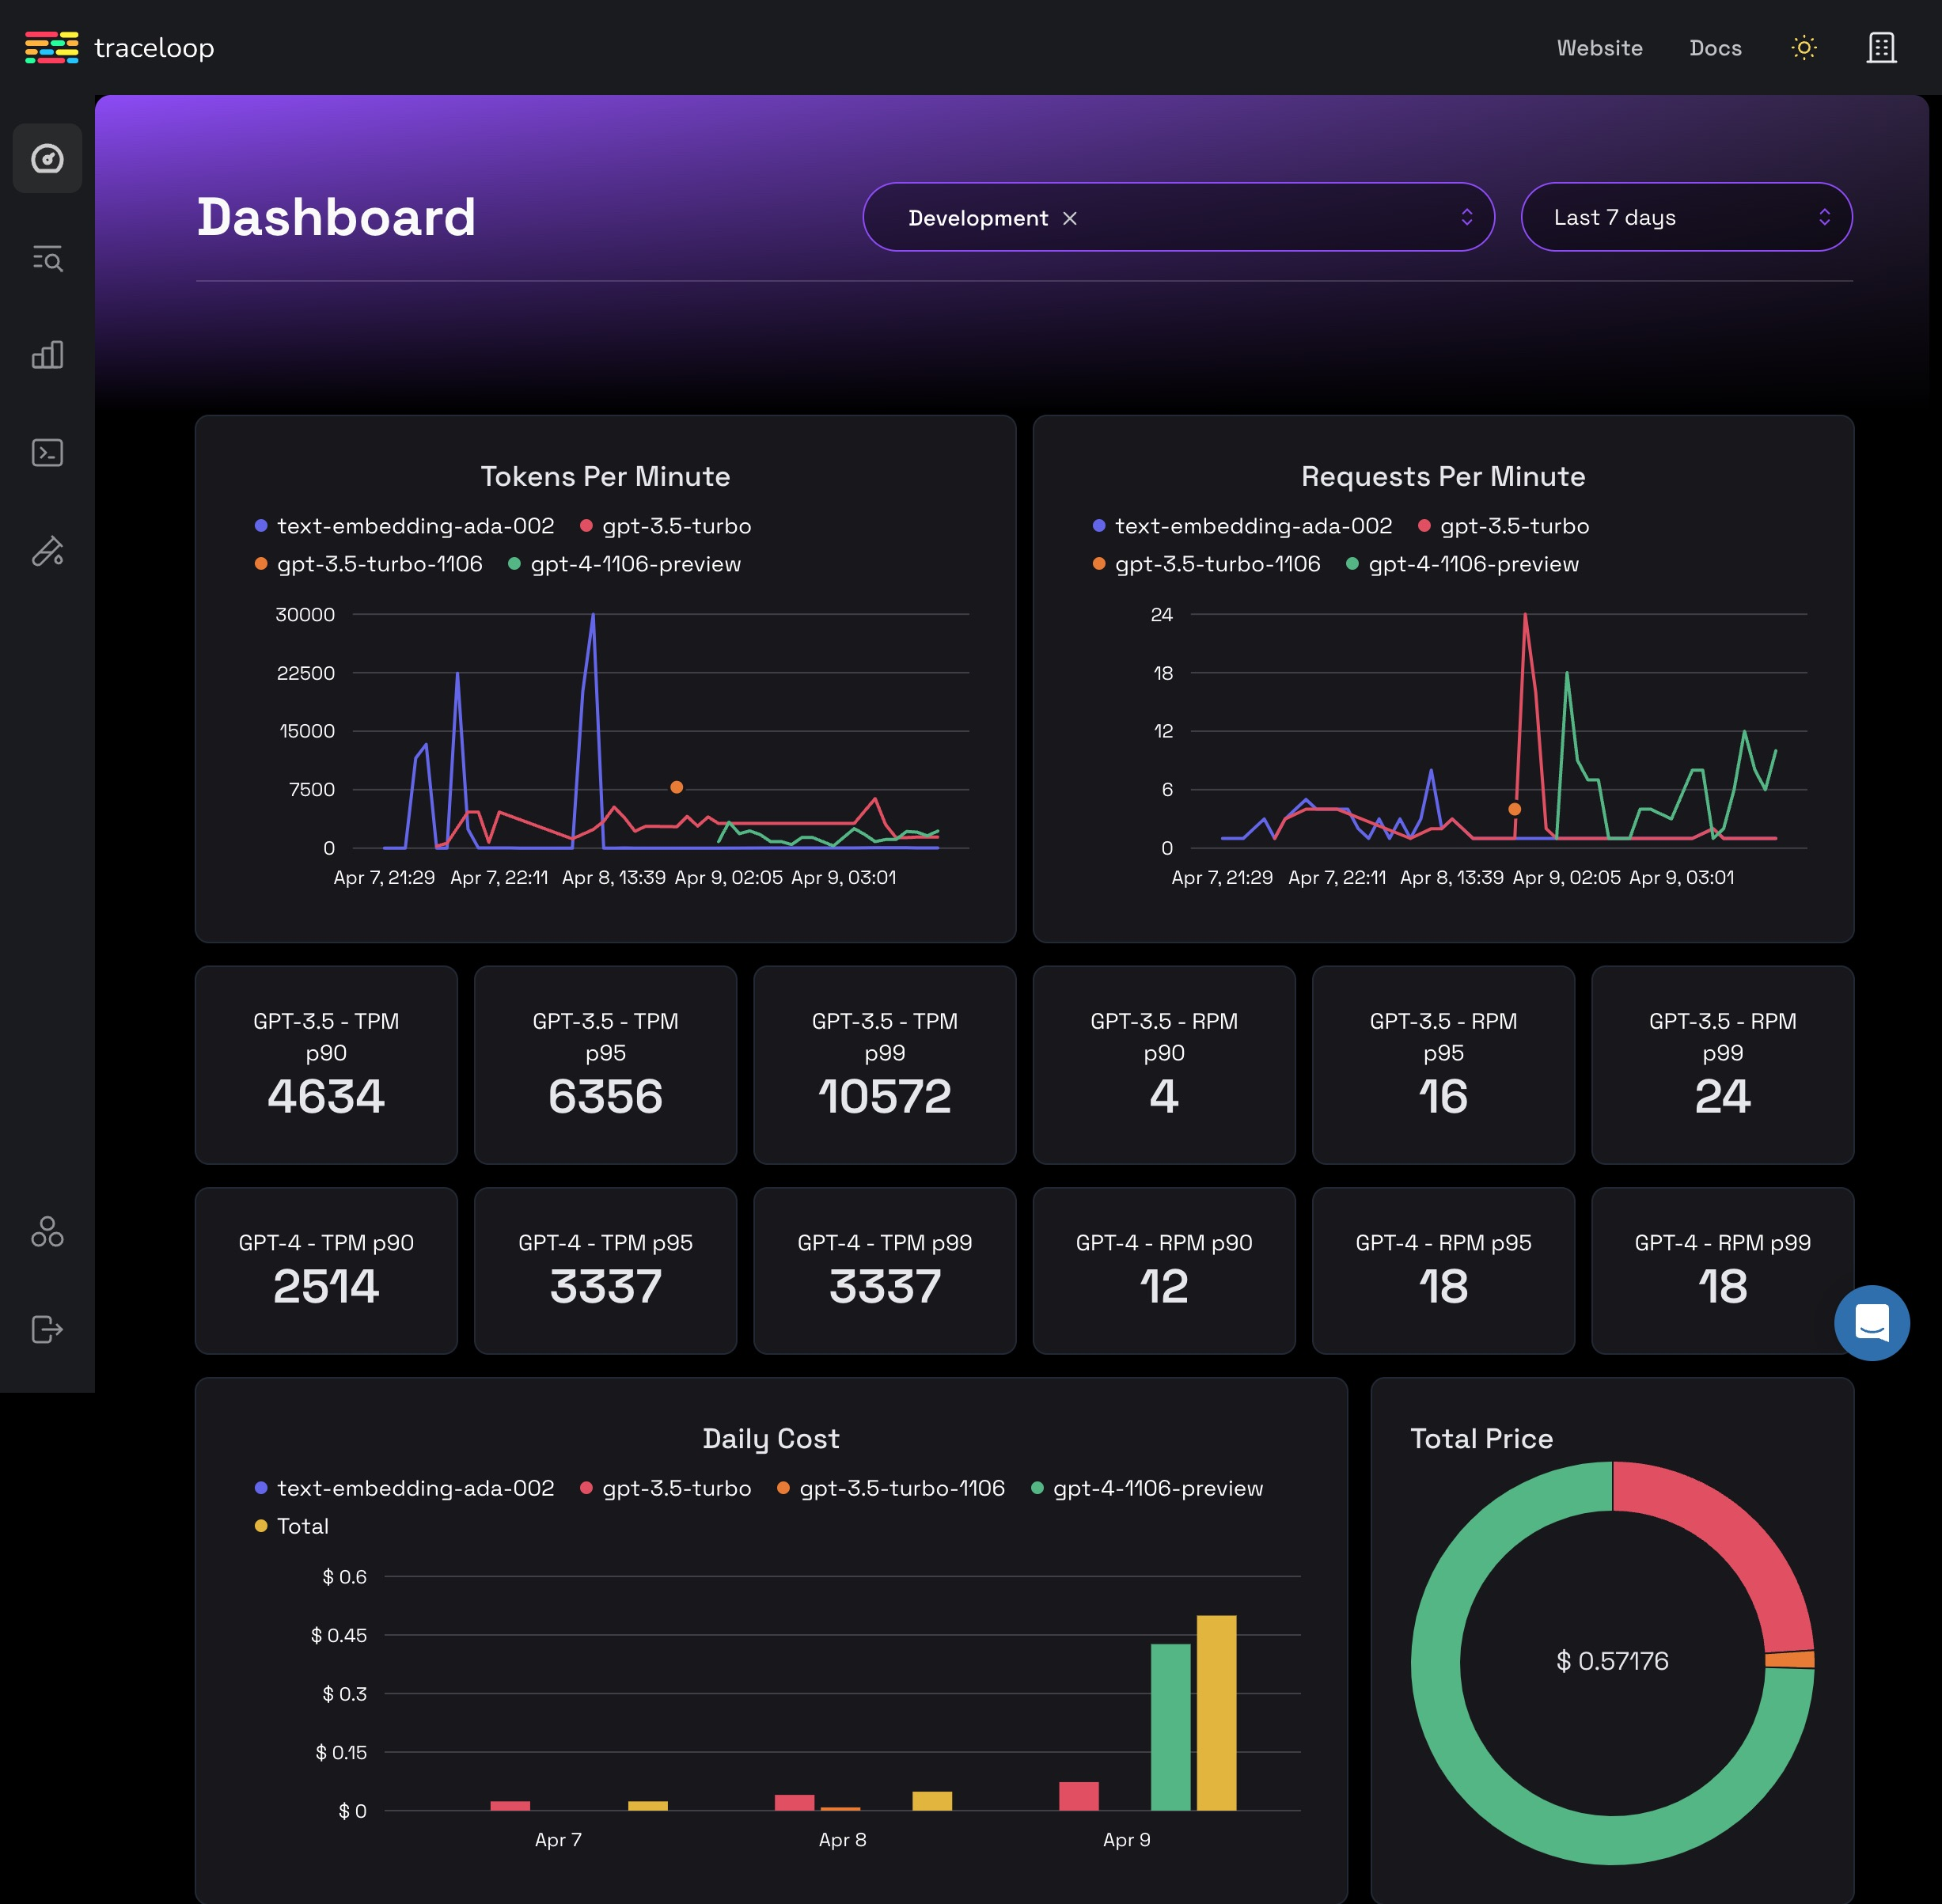

In [110]:
Image(filename='TraceLoop Dashboard.jpeg')

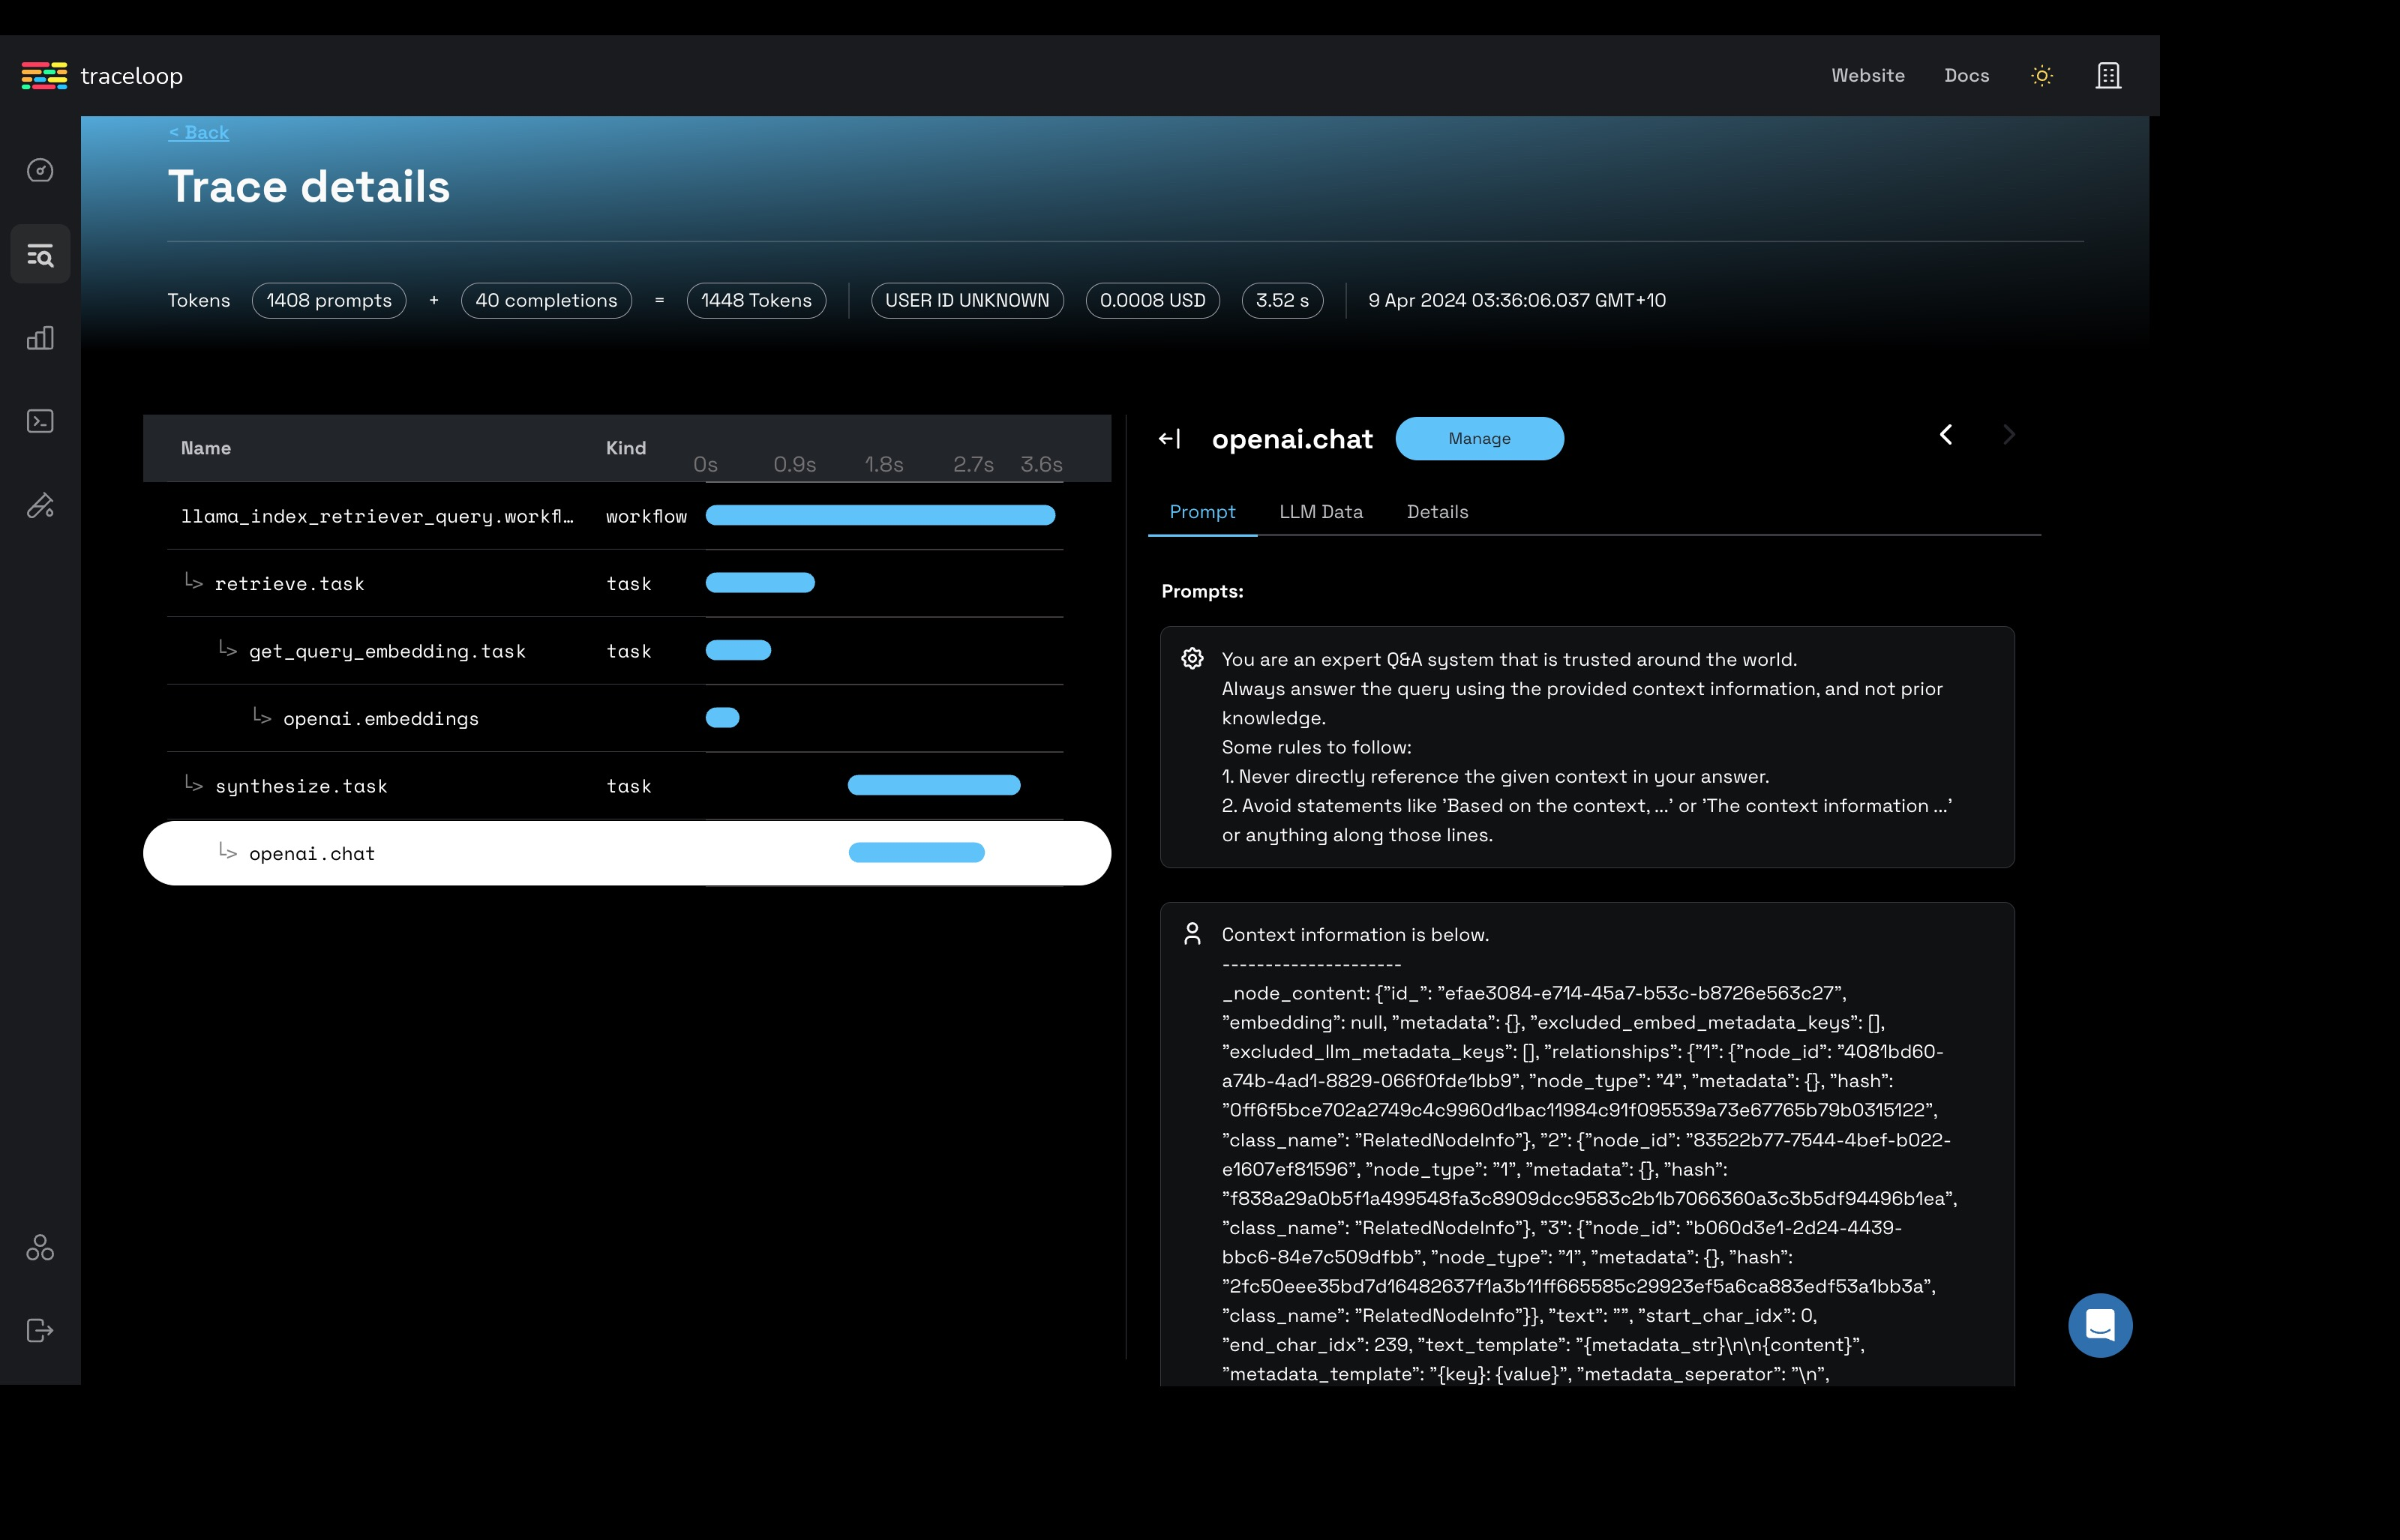

In [111]:
Image('Example trace.jpeg')

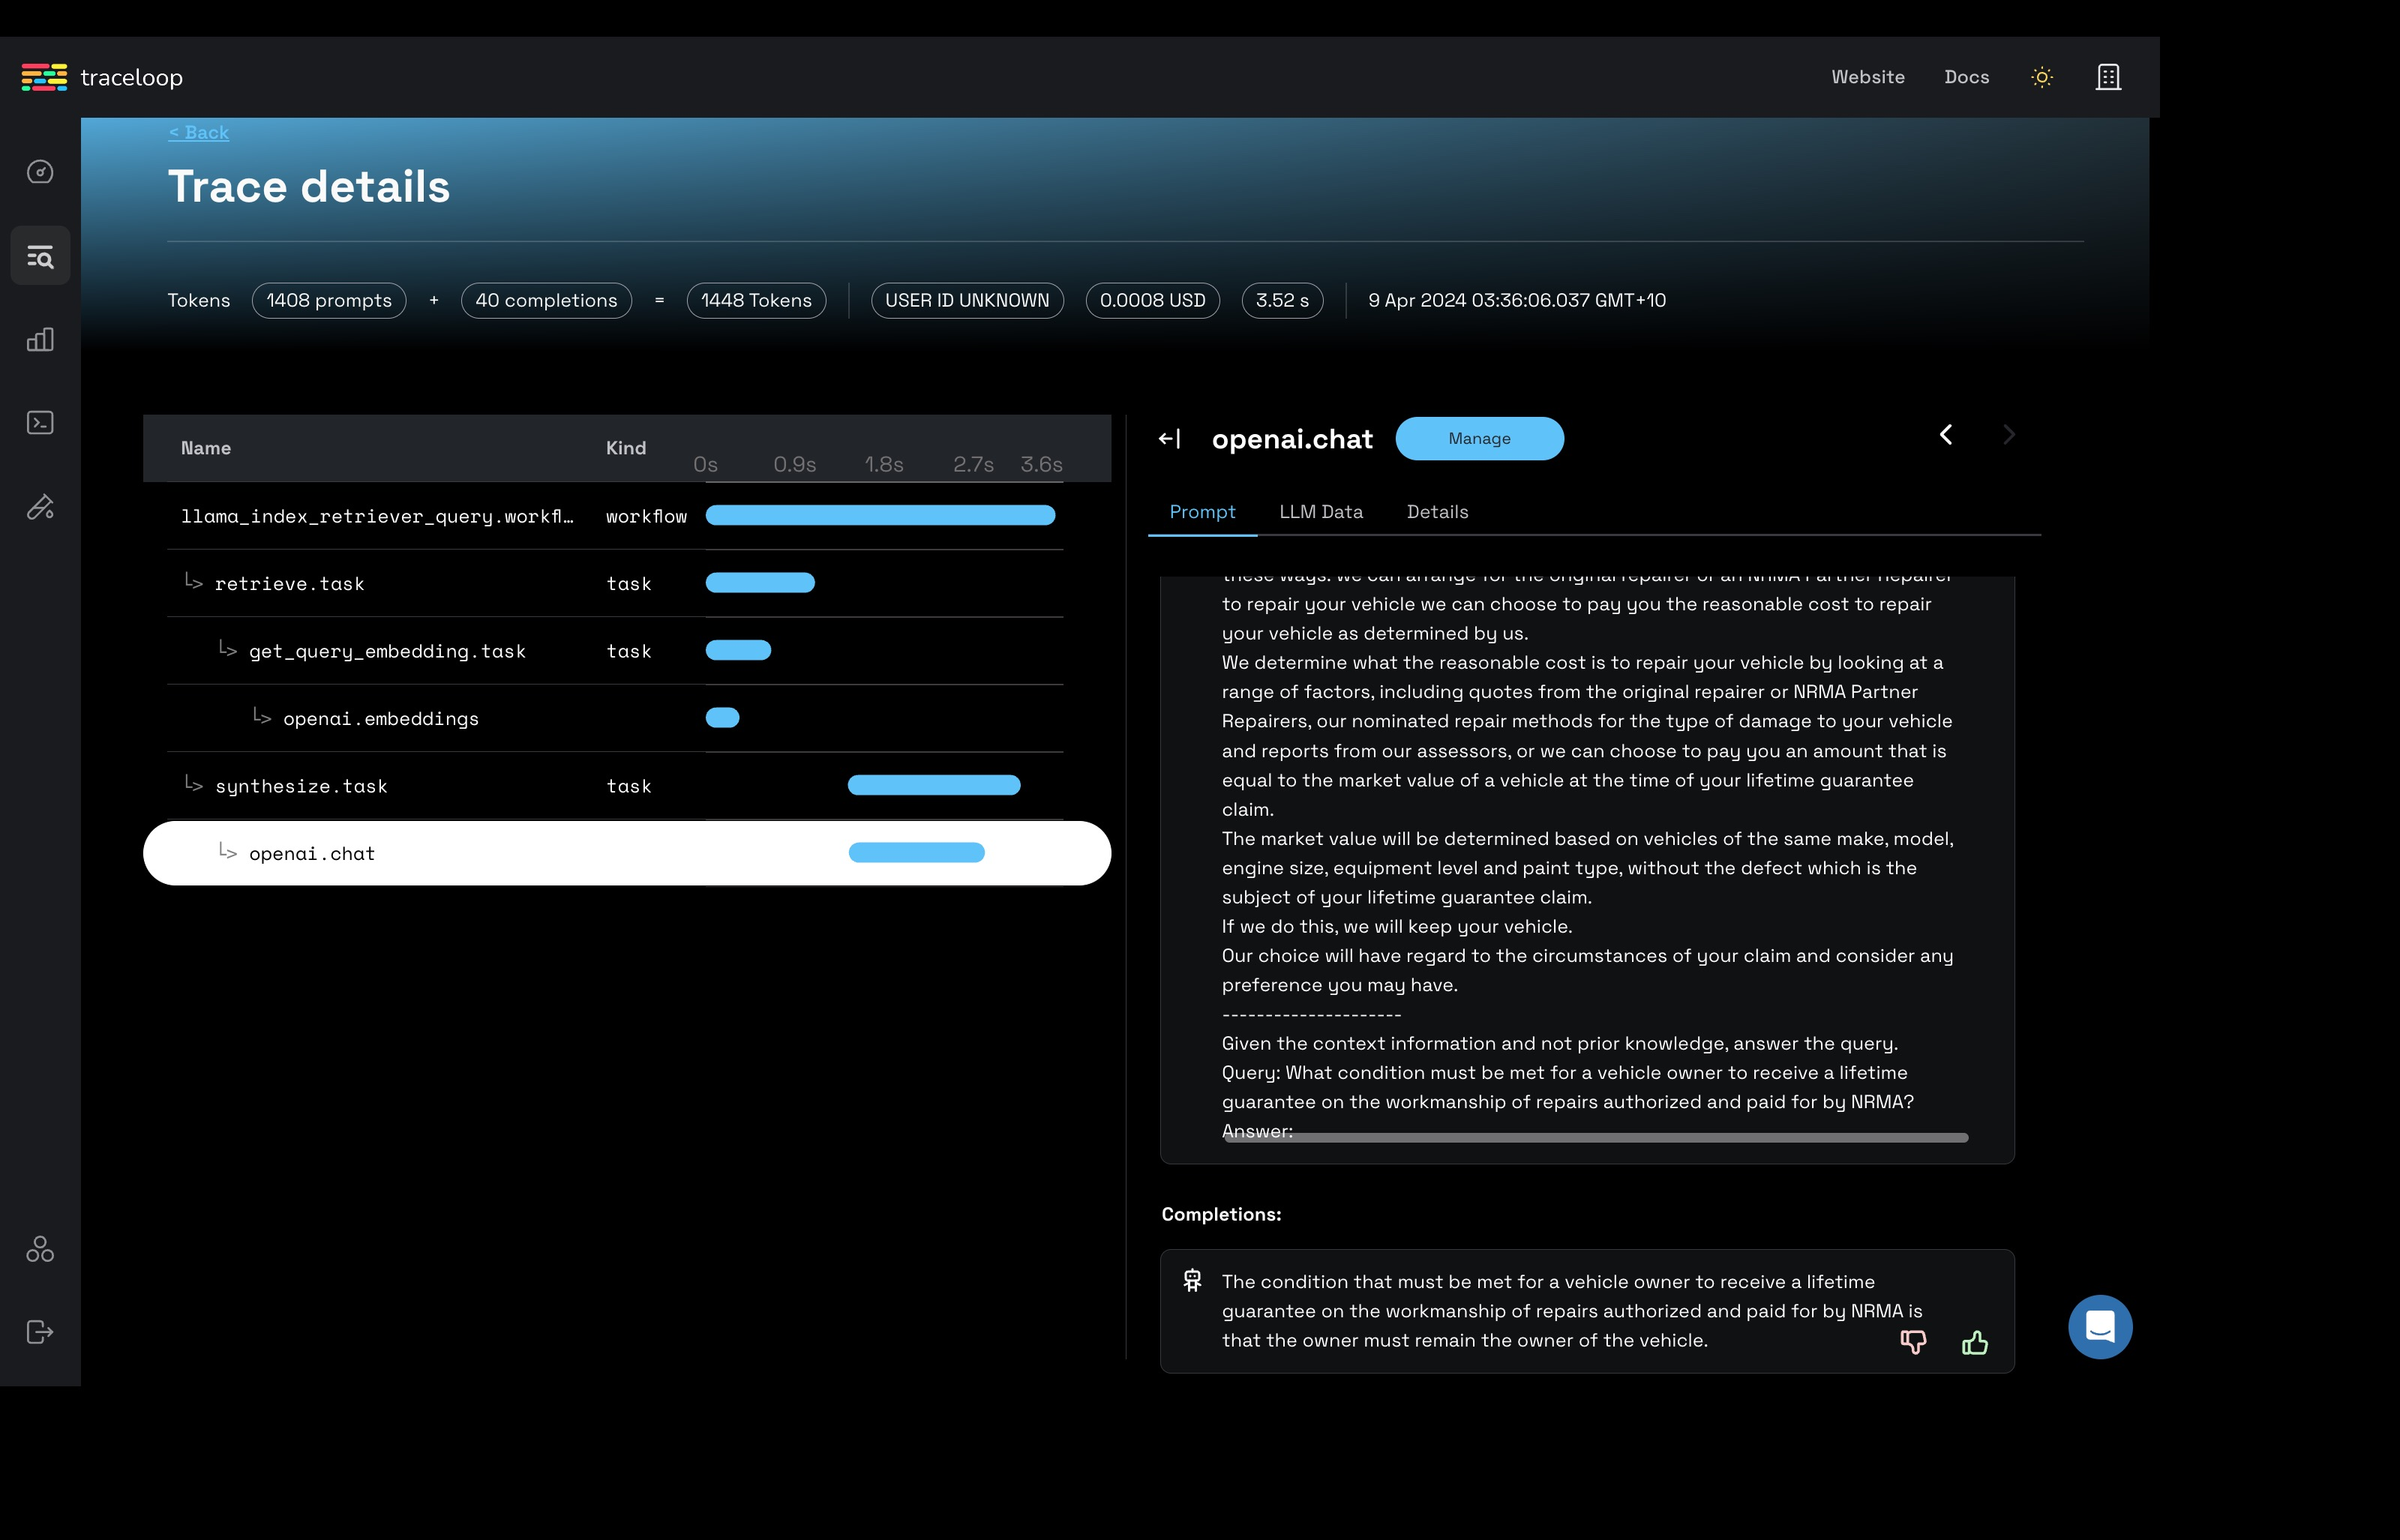

In [112]:
Image('Example trace 2.jpeg')